# Genre song classification
In out database we have spectrograms and chomagrams from different song genres: Alternative, Classical, Dance, Pop, Rock and Techno

### Import needed libraries

In [10]:
# Import general purpose python libraries
import os
import matplotlib.pyplot as plt
from PIL import Image # For handling the images
import numpy as np
from tensorflow import keras

# Import different Keras functionalities
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Add, Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import concatenate
from keras.constraints import MaxNorm
from keras.optimizers import SGD, Adam
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import image_dataset_from_directory
from keras import backend as K


from keras.models import Model
from keras.layers import Input, Dense

from keras.models import load_model
import tensorflow as tf

from keras.applications import ResNet50

from pathlib import Path


# Import function to plot the confussion matrix
import plotcm

### Configuration parameters
Configuration values of different parts of the solution. You should change some of them to obtain better results.

In [11]:
# Randomize the initial network weights
random_seed = True

# Paths to where training, testing, and validation images are
database_dir = '/content/gdrive/MyDrive/2023-2024_VADL_L5_notebook/MIT-CBCL'
train_dir = '/content/gdrive/MyDrive/2023-2024_VADL_L5_notebook/MIT-CBCL/train'
val_dir = '/content/gdrive/MyDrive/2023-2024_VADL_L5_notebook/MIT-CBCL/val'
test_dir = '/content/gdrive/MyDrive/2023-2024_VADL_L5_notebook/MIT-CBCL/test'

# Directory where to store weights of the model and results
experiment_rootdir = "./results/"
# Create experiment directory if it does not exists
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

version = 'Prueba'
weights_path = f"weights_{version}.h5" # Name of the file to store the weights
weights_file = Path(weights_path)

# Output dimension (number of sublects in our problem)
num_classes = 6

# Name of each gesture of the database
CLASSES = ['Alternative', 'Pop', 'Rock', 'Dance', 'Classical', 'Techno']

# Parameters that characterize the images
img_height = 480
img_width = 640
img_channels = 3 # although some images could be rgb, we work with grayscale images
color_mode = 'rgb'

##Configuration of parameters and train, val and test datasets

In [ ]:
# Parameters that configures the training process
batch_size = 1 # Batch size
epochs = 5 # Number of epochs. Set to 20 for this work
initial_lr = 1e-5 # Learning rate

# 1. Generate train dataset (ds) from directory of samples
train_ds = image_dataset_from_directory(directory=train_dir,
                                        label_mode = 'categorical',
                                        class_names=CLASSES,
                                        batch_size=batch_size,
                                        color_mode=color_mode,
                                        image_size=(img_width,img_height), shuffle=True)

# 2. Generate validation dataset (ds) from directory of samples
val_ds  = image_dataset_from_directory(directory=val_dir,
                                       label_mode = 'categorical',
                                       class_names=CLASSES,
                                       batch_size=batch_size,
                                       color_mode=color_mode,
                                       image_size=(img_width,img_height))

# 3. Generate test dataset (ds) from directory of samples
test_ds = image_dataset_from_directory(directory=test_dir,
                                       label_mode = 'categorical',
                                       class_names=CLASSES,
                                       batch_size=batch_size,
                                       color_mode=color_mode,
                                       image_size=(img_width,img_height),
                                       shuffle = False)

##Function def for plots

In [ ]:
def plot_accuracy_loss(history):
  # 1. Plot accuracy
  plt.figure()
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # Save the figure
  fig_save_path = os.path.join(experiment_rootdir, f"accuracy_{version}.png")
  plt.savefig(fig_save_path)

  # Show figure
  plt.show()

  # 2. Plot loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig_save_path = os.path.join(experiment_rootdir, f"loss_{version}.png")
  plt.savefig(fig_save_path)
  plt.show()

# Training process

# Create many models



## VGG-16

In [12]:
def VGG16(img_width,img_height,img_channels):
	#  dropout rate for FC layers
	dropout=0.5

	# CNN architecture
	input_image = Input(shape=(img_width,img_height,img_channels))
	x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
	x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x1)
	x1 = MaxPooling2D((2, 2))(x1)
	x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
	x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
	x1 = MaxPooling2D((2, 2))(x1)
	x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
	x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
	x1 = Conv2D(256, (1, 1),padding='same', activation='relu')(x1)
	x1 = MaxPooling2D((2, 2))(x1)
	x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
	x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
	x1 = Conv2D(512, (1, 1),padding='same', activation='relu')(x1)
	x1 = MaxPooling2D((2, 2))(x1)
	x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
	x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
	x1 = Conv2D(512, (1, 1),padding='same', activation='relu')(x1)
	x1 = MaxPooling2D((2, 2))(x1)

	x1 = Flatten()(x1)

	x=Dense(4096, activation='relu', kernel_constraint=MaxNorm(3))(x1)
	x=Dropout(dropout)(x)
	x=Dense(4096, activation='relu', kernel_constraint=MaxNorm(3))(x)
	x=Dropout(dropout)(x)
	out= Dense(num_classes, activation='softmax')(x)

	model = Model(inputs = input_image, outputs = out);

	return model

model = VGG16(img_width,img_height,img_channels)



## RestNet

In [15]:
def RestNet (img_width,img_height,img_channels):
  dropout=0.5 # Para evitar que haya overfitting cancela algunas conexiones entre las neuronas aleatoriamente.

  # CNN architecture
  input_image = Input(shape=(img_width,img_height,img_channels))
  x0 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
  x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x0)
  x1 = MaxPooling2D((2, 2))(x1)
  x2 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
  x3 = Conv2D(128, (3, 3),padding='same')(x2)
  x4 = Add()([x3, x2])
  x4 = Activation('relu')(x4)
  x4 = MaxPooling2D((2, 2))(x4)
  x4 = Conv2D(256, (3, 3),padding='same', activation='relu')(x4)
  x5 = Conv2D(256, (3, 3),padding='same', activation='relu')(x4)
  x5 = Conv2D(256, (1, 1),padding='same')(x5)
  x6 = Add()([x5, x4])
  x6 = Activation('relu')(x6)
  x6 = MaxPooling2D((2, 2))(x6)
  x6 = Conv2D(512, (3, 3),padding='same', activation='relu')(x6)
  x7 = Conv2D(512, (3, 3),padding='same', activation='relu')(x6)
  x7 = Conv2D(512, (1, 1),padding='same')(x7)
  x8 = Add()([x7, x6])
  x8 = Activation('relu')(x8)
  x8 = MaxPooling2D((2, 2))(x8)
  x8 = Conv2D(512, (3, 3),padding='same', activation='relu')(x8)
  x9 = Conv2D(512, (3, 3),padding='same', activation='relu')(x8)
  x9 = Conv2D(512, (1, 1),padding='same')(x9)
  x10 = Add()([x9, x8])
  x10 = Activation('relu')(x10)
  x10 = MaxPooling2D((2, 2))(x10)
  x10 = Flatten()(x10)

  x=Dense(4096, activation='relu', kernel_constraint=MaxNorm(3))(x10)
  x=Dropout(dropout)(x)
  x=Dense(4096, activation='relu', kernel_constraint=MaxNorm(3))(x)
  x=Dropout(dropout)(x)
  out= Dense(num_classes, activation='softmax')(x)

  model = Model(inputs = input_image, outputs = out);

  return model

## Model execution

In [16]:
#Load parameters
if weights_file.is_file():
	model.load_weights(weights_path)

#Model
model = RestNet(img_width,img_height,img_channels)

# Print the architecture of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 150, 150, 1)]        0         []                            
                                                                                                  
 conv2d_52 (Conv2D)          (None, 150, 150, 64)         640       ['input_5[0][0]']             
                                                                                                  
 conv2d_53 (Conv2D)          (None, 150, 150, 64)         36928     ['conv2d_52[0][0]']           
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 75, 75, 64)           0         ['conv2d_53[0][0]']           
 ng2D)                                                                                      

### Set model training process
Configuration of several training decisions:
1. Optimizer using `Adam`
2. Model training configuration using `compile`. Use a loss and a metric function appropriate for the task
3. Creation of the data generator for the training dataset using `image_dataset_from_directory`
4. Creation of the data generator for the validation dataset using `image_dataset_from_directory`

In [17]:
# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)


# 1. Configure optimizer
adam = Adam(learning_rate=initial_lr)

# 2. Configure training process
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])


Found 1210 files belonging to 10 classes.
Found 400 files belonging to 10 classes.


### Train the model
1. Load parameters from previous trainings if they exist.
2. Fit the model
3. Save the weights

In [18]:
# Load pretrained model
weights_load_path = os.path.join(experiment_rootdir, weights_path)
if weights_load_path:
    try:
        model.load_weights(weights_load_path)
        print("Loaded model from {}".format(weights_load_path))
    except:
        print("Impossible to find weight path. Returning untrained model")

# Fit the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

# Save weights
weights_save_path = os.path.join(experiment_rootdir, weights_path)
model.save_weights(weights_save_path)

Impossible to find weight path. Returning untrained model
Epoch 1/5
1210/1210 [==============================] - 266s 209ms/step - loss: 2.2196 - categorical_accuracy: 0.4719 - val_loss: 0.3194 - val_categorical_accuracy: 0.9175
Epoch 2/5
1210/1210 [==============================] - 51s 43ms/step - loss: 0.4181 - categorical_accuracy: 0.8504 - val_loss: 0.1100 - val_categorical_accuracy: 0.9425
Epoch 3/5
1210/1210 [==============================] - 49s 41ms/step - loss: 0.2100 - categorical_accuracy: 0.9289 - val_loss: 0.0226 - val_categorical_accuracy: 0.9950
Epoch 4/5
1210/1210 [==============================] - 55s 45ms/step - loss: 0.1359 - categorical_accuracy: 0.9512 - val_loss: 0.0094 - val_categorical_accuracy: 0.9975
Epoch 5/5
1210/1210 [==============================] - 51s 42ms/step - loss: 0.0660 - categorical_accuracy: 0.9777 - val_loss: 0.0129 - val_categorical_accuracy: 0.9950


### Plot history for accuracy and loss for the training  process

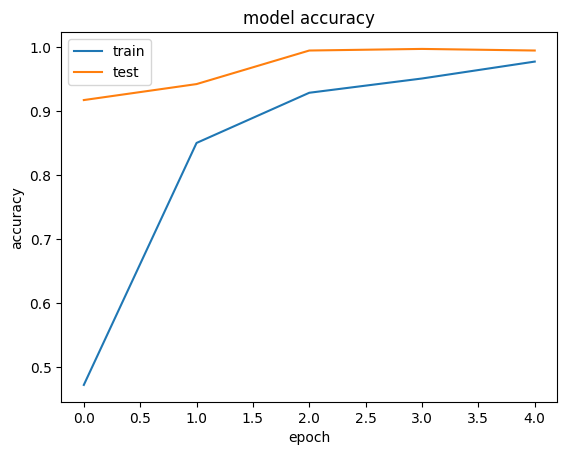

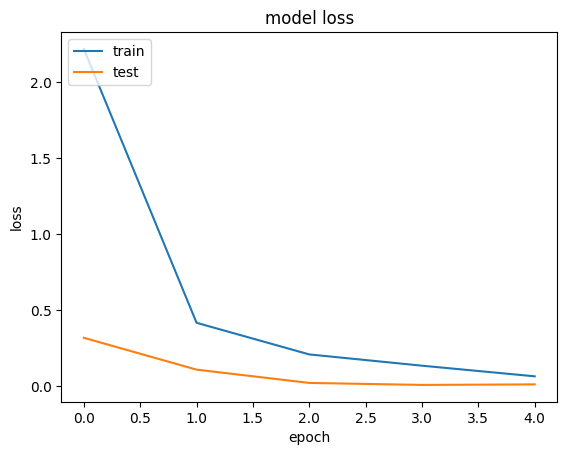

In [26]:
plot_accuracy_loss(history)

# Testing

### Testing process
Compute the loss function and accuracy for the test data (using `evaluate`)

In [22]:
# Evaluate model
scores = model.evaluate(test_ds, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f%%" % scores[0])

### Generation of the predictions and the confusion matrix for the test data
1.   Compute predictions with `predict`
2.   Select the most probable class with `argmax`

The confusion matrix will be shown with `plotcm`


420/420 [==============================] - 72s 170ms/step


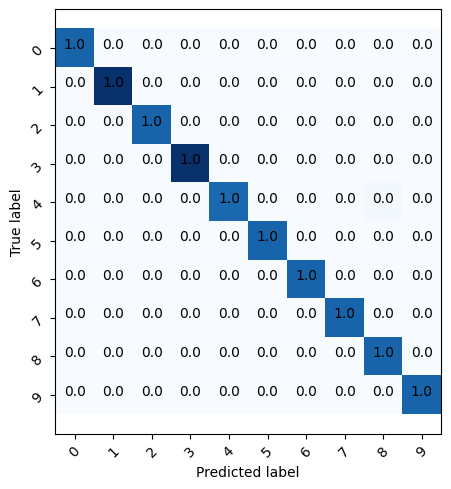

In [23]:

# 1. Get predictions
prob_class = model.predict(test_ds, batch_size=batch_size)

# 2. Prediced labels
y_pred = tf.argmax(prob_class, axis=-1)

# Get ground truth
y_true = tf.argmax(tf.concat([label for image, label in test_ds], axis=0), axis=1)

# Visualize confusion matrix                                           
plotcm.plotcm(experiment_rootdir, version, y_true, y_pred, CLASSES, experiment_rootdir, normalize=True)